SCM Instantiated Successfully.

Plotting SCM graph...


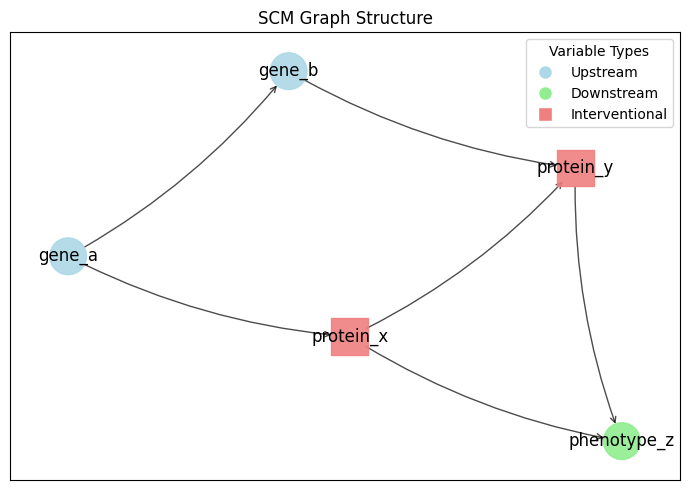


Sampling observational data (default cell line)...
   gene_a     gene_b  protein_x  protein_y  phenotype_z
0     4.0   7.643457   7.883321  15.482937     7.850875
1     4.0   8.119664   7.614927  16.155031     7.440134
2     7.0  13.285694  23.917830  39.908090    16.391371
3     2.0   3.935763   2.866892   6.832429     3.510743
4     5.0  10.316849  12.973370  23.361532    10.627121

Sampling with single intervention: set_protX_high = 5.0 ...
   gene_a     gene_b  protein_x  protein_y  phenotype_z
0    10.0  19.784861        5.0  21.022316    12.085487
1     4.0   7.353696        5.0  11.620322     5.151046
2     2.0   3.833821        5.0   9.493329     4.009516
3     4.0   7.403065        5.0  13.112300     7.110019
4     3.0   5.707080        5.0  10.477142     4.519448
Mean Protein X (Intervention High): 5.00
Mean Phenotype Z (Intervention High): 7.41

Sampling with COMBINED interventions: set_protX_low = -2.0 AND set_protY_fixed = 10.0 ...
   gene_a     gene_b  protein_x  protein

In [7]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import inspect
from typing import List, Dict, Callable, Any, Optional, Union, Tuple, Set

# Default noise generation function (Gaussian)
def no_noise(size: int, strength: float) -> np.ndarray:
    """Generates no noise (zeros)."""
    return np.zeros(size)

def gaussian_noise(size: int, strength: float) -> np.ndarray:
    """Generates Gaussian noise."""
    return np.random.normal(loc=0.0, scale=strength, size=size)

# Example alternative noise generation function (Uniform)
def uniform_noise(size: int, strength: float) -> np.ndarray:
    """Generates Uniform noise."""
    limit = np.sqrt(3) * strength
    return np.random.uniform(low=-limit, high=limit, size=size)

NOISE_GENERATORS = {
    'noiseless': no_noise,
    'gaussian': gaussian_noise,
    'uniform': uniform_noise,
}

class StructuralCausalModel:
    """
    Represents and samples from a Structural Causal Model (SCM).

    Handles variable groups (upstream/variant), perfect do-interventions
    (single or combined) with strength per intervention, graph structure constraints,
    plotting, context parameters (e.g., cell lines), and global noise settings.
    """

    def __init__(self,
                 structural_equations: Dict[str, Callable],
                 upstream_vars: Set[str],
                 interventional_vars: Set[str],
                 downstream_vars: Set[str],
                 intervention_definitions: Dict[str, str], # {intervention_type_name: target_variable}
                 noise_strength: float = 1.0,
                 noise_type: str = 'gaussian',
                 default_context_params: Optional[Dict[str, Any]] = None):
        """
        Initializes the Structural Causal Model.

        Args:
            structural_equations: Dictionary mapping variable names (str) to
                their generating functions (Callable). Functions should accept
                parent values as keyword arguments and optionally 'context_params'
                and 'n_samples'.
            upstream_vars: Set of variable names considered upstream (invariant).
            interventional_vars: Set of variable names that can be intervened upon.
            downstream_vars: Set of variable names downstream of interventional vars.
            intervention_definitions: Dictionary mapping intervention type names
                (e.g., "perturb_geneA") to the specific variable name they target
                (e.g., "geneA").
            noise_strength: Global scaling factor for the noise term added to
                each non-intervened variable (default: 1.0).
            noise_type: Type of noise distribution ('gaussian' or 'uniform').
                (default: 'gaussian').
            default_context_params: Optional dictionary of default parameters
                passed to structural equations (simulating e.g., cell lines).
                These can be overridden during sampling.
        """
        self.structural_equations = structural_equations
        self.upstream_vars = upstream_vars
        self.interventional_vars = interventional_vars
        self.downstream_vars = downstream_vars
        self.intervention_definitions = intervention_definitions
        self.noise_strength = noise_strength
        self.default_context_params = default_context_params if default_context_params else {}

        # Combine interventional and downstream into variant variables
        self.variant_vars = self.interventional_vars.union(self.downstream_vars)
        self.all_vars = self.upstream_vars.union(self.variant_vars)

        # Select noise generation function
        if noise_type not in NOISE_GENERATORS:
            raise ValueError(f"Unsupported noise_type: {noise_type}. "
                             f"Available types: {list(NOISE_GENERATORS.keys())}")
        self.noise_generator = NOISE_GENERATORS[noise_type]
        self.noise_type = noise_type

        # Build graph and validate
        self._build_graph()
        self._validate_inputs()
        self._topological_sort = list(nx.topological_sort(self.graph))

    def _get_parents(self, var: str) -> List[str]:
        """Infers parents from the signature of the structural equation."""
        func = self.structural_equations[var]
        sig = inspect.signature(func)
        # Parents are arguments that are not 'n_samples' or 'context_params'
        parents = [p for p in sig.parameters
                   if p not in ['n_samples', 'context_params']]
        return parents

    def _build_graph(self):
        """Builds the NetworkX graph representation from structural equations."""
        self.graph = nx.DiGraph()
        self.graph.add_nodes_from(self.all_vars)
        for var in self.all_vars:
            if var not in self.structural_equations:
                 continue # Roots handled if they appear as parents

            parents = self._get_parents(var)
            for parent in parents:
                if parent not in self.all_vars:
                    raise ValueError(f"Parent '{parent}' of variable '{var}' "
                                     f"is not defined in upstream, interventional, "
                                     f"or downstream variables.")
                self.graph.add_edge(parent, var)

        if not nx.is_directed_acyclic_graph(self.graph):
            cycles = list(nx.simple_cycles(self.graph))
            raise ValueError(f"The defined structure contains cycles: {cycles}")


    def _validate_inputs(self):
        """Performs validation checks on the SCM definition."""
        # [Validation checks remain the same as before]
        # 1. Check variable uniqueness across groups
        if not self.upstream_vars.isdisjoint(self.interventional_vars):
            raise ValueError("Overlap detected between upstream and interventional variables.")
        if not self.upstream_vars.isdisjoint(self.downstream_vars):
             raise ValueError("Overlap detected between upstream and downstream variables.")
        if not self.interventional_vars.isdisjoint(self.downstream_vars):
             raise ValueError("Overlap detected between interventional and downstream variables.")

        # 2. Check if all variables with equations are in the defined sets
        for var in self.structural_equations:
            if var not in self.all_vars:
                raise ValueError(f"Variable '{var}' in structural_equations "
                                 f"is not defined in any variable group.")

        # 3. Check intervention definitions
        for int_type, target_var in self.intervention_definitions.items():
            if target_var not in self.interventional_vars:
                raise ValueError(f"Intervention '{int_type}' targets variable "
                                 f"'{target_var}', which is not in the defined "
                                 f"interventional_vars set.")

        # 4. Requirement 3: No upstream descendants of *variant* variables
        for u, v in self.graph.edges():
            if u in self.variant_vars and v in self.upstream_vars:
                raise ValueError(f"Invalid edge: Cannot have an edge from a "
                                 f"variant variable ('{u}') to an upstream "
                                 f"variable ('{v}').")

        # 5. Check if all non-root variables have structural equations
        roots = {node for node, degree in self.graph.in_degree() if degree == 0}
        vars_needing_eqs = self.all_vars - roots
        missing_eqs = vars_needing_eqs - set(self.structural_equations.keys())
        # Allow roots defined only by noise (no parents) not to have explicit equation
        # if they don't appear as parents elsewhere? No, better to require equation for all.
        # Let's ensure all variables have an equation for clarity.
        missing_eqs_all = self.all_vars - set(self.structural_equations.keys())
        if missing_eqs_all:
            raise ValueError(f"Missing structural equations for variables: {missing_eqs_all}")


    def plot_graph(self, ax=None, layout='kamada_kawai', **kwargs):
        """
        Plots the causal graph structure using NetworkX and Matplotlib.

        Args:
            ax: Matplotlib axes object to plot on. If None, creates a new figure.
            layout: NetworkX layout function name (e.g., 'kamada_kawai', 'spring',
                    'circular') or a precomputed layout dictionary.
            **kwargs: Additional keyword arguments passed to nx.draw().
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=kwargs.pop('figsize', (8, 6)))
            # Don't set suptitle here, let the main script do it if desired
            # fig.suptitle("SCM Graph Structure")

        node_colors = []
        node_shapes = [] # o for upstream/downstream, s for interventional
        for node in self.graph.nodes():
            if node in self.upstream_vars:
                node_colors.append('lightblue')
                node_shapes.append('o')
            elif node in self.interventional_vars:
                node_colors.append('lightcoral')
                node_shapes.append('s') # Square for interventional
            elif node in self.downstream_vars:
                node_colors.append('lightgreen')
                node_shapes.append('o')
            else:
                node_colors.append('gray') # Should not happen with validation
                node_shapes.append('d')

        # Use a layout algorithm or precomputed positions
        if isinstance(layout, str):
            try:
                layout_func = getattr(nx, f"{layout}_layout")
                pos = layout_func(self.graph)
            except AttributeError:
                 print(f"Warning: Layout '{layout}' not found in NetworkX. Using 'kamada_kawai_layout'.")
                 pos = nx.kamada_kawai_layout(self.graph)
        elif isinstance(layout, dict):
            pos = layout
        else:
            # Default layout
            pos = nx.kamada_kawai_layout(self.graph)


        # Draw nodes distinctly by shape requires drawing nodes separately
        unique_shapes = sorted(list(set(node_shapes))) # Sort for consistent legend order
        handles = []
        labels = {'o': 'Upstream/Downstream', 's': 'Interventional'} # Adjust label map

        node_kwargs = { # Default node drawing options
            'node_size': 700,
            'alpha': 0.9
        }
        node_kwargs.update(kwargs) # Allow overriding via plot_graph call

        for shape in unique_shapes:
            shaped_nodes = [node for node, s in zip(self.graph.nodes(), node_shapes) if s == shape]
            shaped_colors = [color for color, s in zip(node_colors, node_shapes) if s == shape]

            # Map shape character to a color for the legend handle (use average color?)
            # Simpler: use predefined colors for legend handles
            if shape == 's': # Interventional
                 handle_color = 'lightcoral'
                 label_text = 'Interventional'
                 handles.append(plt.Line2D([0], [0], marker=shape, color='w', label=label_text, markersize=10, markerfacecolor=handle_color))
            elif shape == 'o': # Upstream / Downstream need separate handles
                # Check which types are present
                has_upstream = any(n in self.upstream_vars for n in shaped_nodes)
                has_downstream = any(n in self.downstream_vars for n in shaped_nodes)
                if has_upstream:
                     handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Upstream', markersize=10, markerfacecolor='lightblue'))
                if has_downstream:
                     handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Downstream', markersize=10, markerfacecolor='lightgreen'))

            nx.draw_networkx_nodes(self.graph, pos,
                                   nodelist=shaped_nodes,
                                   node_color=shaped_colors,
                                   node_shape=shape, ax=ax, **node_kwargs)


        # Draw edges and labels
        edge_kwargs = {
             'arrowstyle': '->',
             'connectionstyle':'arc3,rad=0.1',
             'node_size': node_kwargs.get('node_size', 700), # Make arrows point near node edge
             'alpha': 0.7
        }
        nx.draw_networkx_edges(self.graph, pos, ax=ax, **edge_kwargs)
        nx.draw_networkx_labels(self.graph, pos, ax=ax)

        # Add legend
        ax.legend(handles=handles, title="Variable Types", loc='best')
        ax.set_title("SCM Graph Structure")
        plt.tight_layout()
        # Don't call plt.show() here, let the calling script manage figures
        # plt.show()


    def sample(self,
               n_samples: int = 1,
               interventions: Optional[Dict[str, float]] = None, # CHANGED: Dict {type: strength}
               context_params: Optional[Dict[str, Any]] = None) -> pd.DataFrame:
        """
        Samples data from the SCM, applying optional interventions with specific strengths.

        Args:
            n_samples: Number of samples to generate.
            interventions: Dictionary mapping intervention type names (str) to
                           their desired perturbation strengths (float).
                           Example: {'set_protX_high': 5.0, 'set_protY_low': -2.0}.
                           If None, observational data is sampled.
            context_params: Dictionary of context parameters (e.g., cell line
                            specifics) to potentially override defaults and pass
                            to structural equations.

        Returns:
            Pandas DataFrame containing the sampled data, with columns for
            each variable.
        """
        samples = pd.DataFrame(index=range(n_samples), columns=self._topological_sort, dtype=float)
        intervention_targets = {} # Map from target variable to its specific perturbation strength

        # Process interventions using the new dictionary format
        if interventions:
            if not isinstance(interventions, dict):
                 raise TypeError("The 'interventions' argument must be a dictionary "
                                 "mapping intervention type names to their strengths (float), "
                                 "or None.")

            active_targets = set() # To check for multiple interventions on the same target
            for int_type, strength in interventions.items():
                if int_type not in self.intervention_definitions:
                    raise ValueError(f"Unknown intervention type: '{int_type}'. "
                                     f"Defined types: {list(self.intervention_definitions.keys())}")

                target_var = self.intervention_definitions[int_type]

                if target_var in active_targets:
                     raise ValueError(f"Variable '{target_var}' is targeted by multiple "
                                      f"interventions ({int_type} and previous) in the "
                                      f"same sampling call via the interventions dictionary. "
                                      f"This is ambiguous.")

                if not isinstance(strength, (int, float)):
                     raise TypeError(f"Strength for intervention '{int_type}' must be a "
                                     f"number (float or int), got {type(strength).__name__}.")

                intervention_targets[target_var] = float(strength) # Store target and its strength
                active_targets.add(target_var)

        # Combine default and provided context parameters
        current_context = self.default_context_params.copy()
        if context_params:
            current_context.update(context_params)


        # Generate samples following topological order
        for var in self._topological_sort:
            structural_eq = self.structural_equations.get(var)
            if structural_eq is None:
                 # This case should ideally be caught by validation ensuring all vars have eqs.
                 raise RuntimeError(f"Internal Error: No structural equation found for '{var}' "
                                    f"during sampling, despite passing validation.")

            # Check for intervention ON THIS VARIABLE
            if var in intervention_targets:
                # Apply perfect do-intervention: set value = specific strength for this intervention
                intervention_strength = intervention_targets[var]
                samples[var] = np.full(n_samples, intervention_strength)
            else:
                # Calculate based on structural equation (no intervention on this var)
                parents = self._get_parents(var)
                parent_values = {p: samples[p] for p in parents}

                # Check if context_params or n_samples are needed by the function
                sig = inspect.signature(structural_eq)
                func_args = {}
                if 'context_params' in sig.parameters:
                    func_args['context_params'] = current_context
                if 'n_samples' in sig.parameters:
                    func_args['n_samples'] = n_samples

                # Calculate base value from parents and context
                base_value = structural_eq(**parent_values, **func_args)

                # Add noise (unless it's explicitly handled in the equation)
                noise_already_added = (n_samples > 1 and isinstance(base_value, np.ndarray) and base_value.shape == (n_samples,))

                if not noise_already_added:
                     if not isinstance(base_value, np.ndarray) or base_value.ndim == 0:
                         base_value = np.full(n_samples, base_value)
                     elif base_value.shape != (n_samples,):
                          raise ValueError(f"Structural equation for '{var}' returned unexpected shape "
                                           f"{base_value.shape}, expected ({n_samples},) or scalar.")

                     noise = self.noise_generator(n_samples, self.noise_strength)
                     samples[var] = base_value + noise
                else:
                     samples[var] = base_value # Function handled sampling/noise

        return samples

# ================== EXAMPLE USAGE (Updated) ==================

if __name__ == "__main__":
    # --- Define Structural Equations (same as before) ---
    def eq_gene_a(context_params: Dict, n_samples: int) -> np.ndarray:
        alpha = context_params.get('cell_alpha', 1.0)
        # Return array of size n_samples, assuming noise included internally
        return np.random.poisson(alpha * 5, size=n_samples).astype(float)

    def eq_gene_b(gene_a: np.ndarray) -> np.ndarray:
        return 2.0 * gene_a

    def eq_protein_x(gene_a: np.ndarray, context_params: Dict) -> np.ndarray:
        beta = context_params.get('cell_beta', 0.5)
        # Return deterministic part, noise added by sample()
        return beta * (gene_a**2)

    def eq_protein_y(gene_b: np.ndarray, protein_x: np.ndarray) -> np.ndarray:
        # Return deterministic part
        return 0.8 * gene_b + 1.2 * protein_x

    def eq_phenotype_z(protein_x: np.ndarray, protein_y: np.ndarray) -> np.ndarray:
         # Return deterministic part
         return -0.5 * protein_x + 0.7 * protein_y

    # --- Define SCM Components ---
    structural_equations = {
        'gene_a': eq_gene_a,
        'gene_b': eq_gene_b,
        'protein_x': eq_protein_x,
        'protein_y': eq_protein_y,
        'phenotype_z': eq_phenotype_z
    }

    upstream_vars = {'gene_a', 'gene_b'}
    # Make both protein_x and protein_y interventional for combined example
    interventional_vars = {'protein_x', 'protein_y'}
    downstream_vars = {'phenotype_z'}

    # Define intervention types and their targets
    intervention_definitions = {
        'set_protX_high': 'protein_x',
        'set_protX_low': 'protein_x',
        'set_protY_fixed': 'protein_y',
        'set_protY_other': 'protein_y'
    }

    default_cell_params = {'cell_alpha': 1.0, 'cell_beta': 0.5}
    cell_line_2_params = {'cell_alpha': 1.5, 'cell_beta': 0.8}

    # --- Instantiate the SCM ---
    try:
        scm = StructuralCausalModel(
            structural_equations=structural_equations,
            upstream_vars=upstream_vars,
            interventional_vars=interventional_vars,
            downstream_vars=downstream_vars,
            intervention_definitions=intervention_definitions,
            noise_strength=0.5,
            noise_type='gaussian',
            default_context_params=default_cell_params
        )
        print("SCM Instantiated Successfully.")

        # --- Plot the Graph ---
        print("\nPlotting SCM graph...")
        fig, ax = plt.subplots(figsize=(7, 5)) # Create figure/axes explicitly
        scm.plot_graph(ax=ax) # Pass axes to the method
        plt.show() # Show the plot


        # --- Perform Sampling ---
        n_samples = 1000

        # 1. Sample observational data
        print("\nSampling observational data (default cell line)...")
        obs_data = scm.sample(n_samples=n_samples)
        print(obs_data.head())

        # 2. Sample with single intervention (using the new dictionary format)
        print("\nSampling with single intervention: set_protX_high = 5.0 ...")
        int_data_high = scm.sample(
            n_samples=n_samples,
            interventions={'set_protX_high': 5.0} # Dict format now required
        )
        print(int_data_high.head())
        print(f"Mean Protein X (Intervention High): {int_data_high['protein_x'].mean():.2f}") # Should be 5.0
        print(f"Mean Phenotype Z (Intervention High): {int_data_high['phenotype_z'].mean():.2f}")

        # 3. Sample with combined interventions with *different* strengths
        print("\nSampling with COMBINED interventions: set_protX_low = -2.0 AND set_protY_fixed = 10.0 ...")
        combined_int_data = scm.sample(
            n_samples=n_samples,
            interventions={
                'set_protX_low': -2.0,  # do(protein_x = -2.0)
                'set_protY_fixed': 10.0  # do(protein_y = 10.0)
            },
            context_params=cell_line_2_params # Can still combine with context change
        )
        print(combined_int_data.head())
        print(f"Mean Protein X (Combined Int): {combined_int_data['protein_x'].mean():.2f}") # Should be -2.0
        print(f"Mean Protein Y (Combined Int): {combined_int_data['protein_y'].mean():.2f}") # Should be 10.0
        print(f"Mean Phenotype Z (Combined Int, Cell 2): {combined_int_data['phenotype_z'].mean():.2f}")

        # 4. Example: Combined interventions with the *same* strength
        print("\nSampling with COMBINED interventions: set_protX_high = 4.0 AND set_protY_other = 4.0 ...")
        combined_int_data_same = scm.sample(
            n_samples=n_samples,
            interventions={
                'set_protX_high': 4.0,
                'set_protY_other': 4.0
            }
        )
        print(combined_int_data_same.head())
        print(f"Mean Protein X (Combined Int Same): {combined_int_data_same['protein_x'].mean():.2f}") # Should be 4.0
        print(f"Mean Protein Y (Combined Int Same): {combined_int_data_same['protein_y'].mean():.2f}") # Should be 4.0
        print(f"Mean Phenotype Z (Combined Int Same): {combined_int_data_same['phenotype_z'].mean():.2f}")


    except (ValueError, TypeError) as e:
        print(f"\nError: {e}")
    except Exception as e:
        print(f"\nAn unexpected error occurred: {e}")

Plotting random-linear DAG:


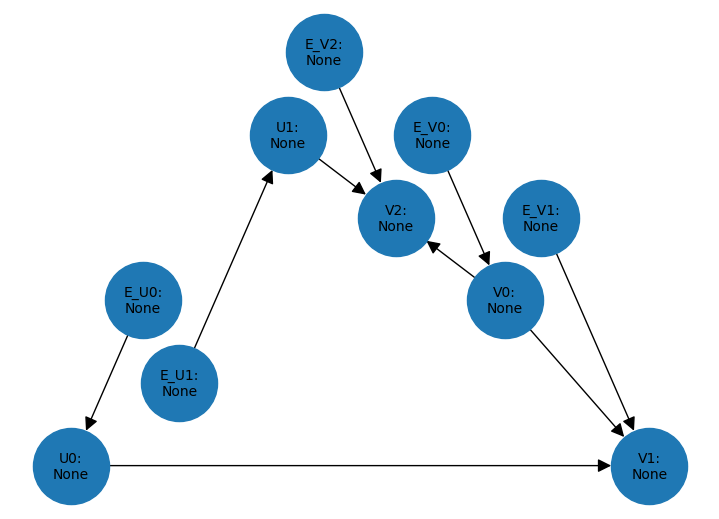

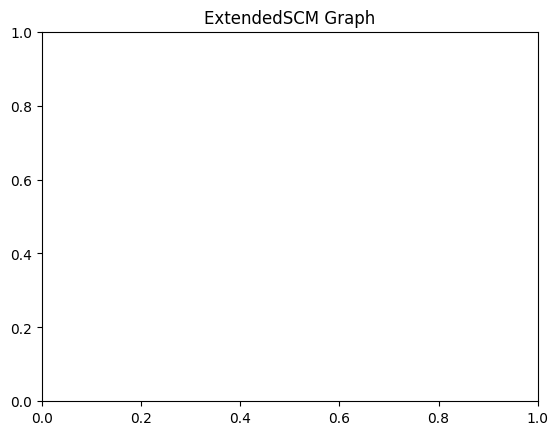

IndexError: list index out of range

In [3]:
# code.py

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Union, Callable

# Import the "StructuralCausalModel" class from your "cuasal-playground.py".
# Make sure that file is on your Python path or in the same folder.
from CausalPlayground import StructuralCausalModel

# Noise generator for linear-Gaussian mode
def linear_gaussian_noise(strength: float = 1.0) -> float:
    return np.random.normal(0.0, strength)

def random_linear_weight() -> float:
    """Generates a random parent weight in a small range."""
    return np.random.uniform(-2.0, 2.0)

class ExtendedSCM:
    """
    A class that constructs and samples from a structural causal model (SCM),
    leveraging the 'StructuralCausalModel' provided in 'cuasal-playground.py'.
    
    Features / Requirements:
      1) Two groups of variables: 
         - Upstream (invariant) vs. Variant (some interventional, some downstream).
      2) k possible perfect do-interventions on the interventional variables.
      3) No upstream descendants of interventional variables (no edges from variant->upstream).
      4) Graph plotting.
      5) Different variable types are possible (though the random linear mode is purely numeric).
      6) Sparse network structure, controlled by an edge probability.
      7) A cell-line or context parameter shift for upstream variables (optional).
      8) Global noise_strength & noise_type (default: Gaussian). 
      
    Additionally:
      - If 'random_linear=True', the code auto-generates a random linear-Gaussian SCM
        (no need to specify each mechanism).
      - Otherwise, you can supply explicit structural equations for each variable (similar to the original code).
    """

    def __init__(
        self,
        upstream_vars: List[str],
        interventional_vars: List[str],
        downstream_vars: List[str],
        k_interventions: int = 2,
        noise_strength: float = 1.0,
        random_linear: bool = False,
        edge_prob: float = 0.2,
        random_state: int = 42,
        # Optional user-specified mechanisms (ignored if random_linear=True)
        structural_equations: Optional[Dict[str, Callable]] = None,
        # For each variable, how to shift it if it's upstream (simulating cell lines, etc.)
        upstream_shifts: Optional[Dict[str, float]] = None,
    ):
        """
        :param upstream_vars: Names of upstream (invariant) variables, e.g. ["U0", "U1"].
        :param interventional_vars: Names of variant variables that can be directly intervened on.
        :param downstream_vars: Names of variant variables that are indirectly affected by interventions.
        :param k_interventions: Number of do-interventions to define for the interventional vars 
                                (one per distinct variable if you want each var to have its own).
        :param noise_strength: Global scale of the noise term for each variable (default=1.0).
        :param random_linear: If True, auto-generate a random linear-Gaussian SCM. If False,
                              you must provide 'structural_equations' for each variable.
        :param edge_prob: Probability of creating an edge in the random DAG (controls sparsity).
        :param random_state: Seed for reproducible random DAG generation & sampling.
        :param structural_equations: If random_linear=False, a dict var->function implementing
                                     the user-specified mechanism. Each function must accept 
                                     the names of its parents as arguments plus an optional
                                     "n_samples" argument. 
        :param upstream_shifts: Dict specifying a numeric shift for each upstream variable
                                (simulating cell-line or context). E.g. {"U0": 2.0, "U1": -1.0}.
        """
        np.random.seed(random_state)
        self.rng = np.random.default_rng(random_state)

        self.upstream_vars = upstream_vars
        self.interventional_vars = interventional_vars
        self.downstream_vars = downstream_vars
        self.all_vars = sorted(upstream_vars + interventional_vars + downstream_vars)

        self.k_interventions = k_interventions
        self.noise_strength = noise_strength
        self.random_linear = random_linear
        self.edge_prob = edge_prob
        self.random_state = random_state
        self.structural_equations = structural_equations or {}
        self.upstream_shifts = upstream_shifts or {}

        # Validate sets for overlap:
        self._validate_variable_sets()

        # Generate adjacency with constraints (no variant->upstream edges)
        self.adjacency = self._create_adjacency()

        # Create a CausalPlayground SCM instance
        self.scm = StructuralCausalModel()

        # Build the DAG in the CausalPlayground SCM
        # For each variable, we'll create an exogenous variable (noise), 
        # then define an assignment function that depends on the parent variables.
        self._build_scm()

        # Predefine possible do-interventions (k of them).
        # Each one sets a distinct interventional var to a numeric value, e.g. do(var = i*some_factor).
        # If you want to apply multiple interventions simultaneously, you'll do that in the sample() method.
        self.interventions = self._define_interventions()

    def _validate_variable_sets(self):
        """Ensure there's no overlap among upstream, interventional, downstream sets."""
        s_up = set(self.upstream_vars)
        s_int = set(self.interventional_vars)
        s_down = set(self.downstream_vars)

        if s_up & s_int:
            raise ValueError("Overlap detected between upstream and interventional variables.")
        if s_up & s_down:
            raise ValueError("Overlap detected between upstream and downstream variables.")
        if s_int & s_down:
            raise ValueError("Overlap detected between interventional and downstream variables.")

    def _create_adjacency(self) -> Dict[str, List[str]]:
        """
        Create a random adjacency (child->parents) with:
         - No edges from variant->upstream
         - Possible edges among upstream themselves, among variant themselves, 
           or from upstream->variant
         - Probability of edge = self.edge_prob
         - Acyclic forced by removing cycles if found
        """
        adjacency = {v: [] for v in self.all_vars}

        # Helper sets
        up_set = set(self.upstream_vars)
        var_set = set(self.interventional_vars + self.downstream_vars)

        # Edges among upstream
        for i in range(len(self.upstream_vars)):
            for j in range(i+1, len(self.upstream_vars)):
                if self.rng.random() < self.edge_prob:
                    # random direction
                    if self.rng.random() < 0.5:
                        adjacency[self.upstream_vars[j]].append(self.upstream_vars[i])
                    else:
                        adjacency[self.upstream_vars[i]].append(self.upstream_vars[j])

        # Edges among variant
        var_list = self.interventional_vars + self.downstream_vars
        for i in range(len(var_list)):
            for j in range(i+1, len(var_list)):
                if self.rng.random() < self.edge_prob:
                    if self.rng.random() < 0.5:
                        adjacency[var_list[j]].append(var_list[i])
                    else:
                        adjacency[var_list[i]].append(var_list[j])

        # Edges from upstream->variant
        for u in self.upstream_vars:
            for v in var_list:
                if self.rng.random() < self.edge_prob:
                    adjacency[v].append(u)

        # Remove cycles if they appear
        nx_g = self._adj_to_nx(adjacency)
        while True:
            try:
                cycle_edges = nx.find_cycle(nx_g, orientation="original")
                if cycle_edges:
                    (u, v, _) = cycle_edges[0]
                    adjacency[v].remove(u)
                    nx_g.remove_edge(u, v)
            except nx.NetworkXNoCycle:
                break

        return adjacency

    @staticmethod
    def _adj_to_nx(adjacency: Dict[str, List[str]]) -> nx.DiGraph:
        """Convert adjacency dict {child:[parents]} to a networkx DiGraph."""
        g = nx.DiGraph()
        for child, parents in adjacency.items():
            g.add_node(child)
            for p in parents:
                g.add_edge(p, child)
        return g

    def _build_scm(self):
        """
        Build the underlying CausalPlayground.StructuralCausalModel by adding:
         - one exogenous variable per child (noise)
         - an endogenous variable for each node
           - the assignment function is either from user structural_equations 
             or random linear if self.random_linear=True
        """
        # 1) We'll add an exogenous variable for each child, named E_{child},
        #    which we treat as random noise.
        # 2) We'll add an endogenous var for each 'child' with a function referencing its parents + E_{child}.

        # We'll create a topological order to ensure we handle upstream first, etc.
        nx_graph = self._adj_to_nx(self.adjacency)
        topo_order = list(nx.topological_sort(nx_graph))

        # Add exogenous variable for each node
        for node in self.all_vars:
            exo_name = f"E_{node}"
            # We'll choose e.g. random.randint? The user wants a normal distribution. We'll do random.gauss?
            # For consistency, we can do random.gauss(0, self.noise_strength).
            # We'll store the distribution as a lambda plus kwargs.
            # E.g. random.gauss + {"mu":0, "sigma":self.noise_strength}
            self.scm.add_exogenous_var(
                exo_name,
                distribution = np.random.normal,
                distribution_kwargs = {"loc": 0.0, "scale": self.noise_strength}
            )

        # Now define each node as an endogenous variable
        for node in topo_order:
            parent_list = self.adjacency[node]
            exo_name = f"E_{node}"

            # Build the param->scm_var mapping for the function
            # The exogenous var will appear e.g. as param 'noise'
            param_map = {}
            # We'll pass each parent's value as param "p0", "p1", ... if random linear,
            # or the parent's name if user eq. 
            # But the CausalPlayground requires we pass param->varName in uppercase typically
            # We'll keep it consistent but the library's actual usage doesn't strictly enforce uppercase if we handle it carefully.

            # If we have a user eq, we might want to replicate their function signature. But it's simpler in random linear mode.
            # We'll unify by just always passing parent's name as the param name. So e.g. param_map["X"] = parent. 
            # For the exogenous variable, param_map["noise"] = exo_name
            for p in parent_list:
                param_map[p] = p.upper()
            param_map["noise"] = exo_name.upper()

            # Decide the function for node
            if self.random_linear:
                # We'll create a linear combination of its parents plus an optional shift if node is upstream
                # e.g.  node_value = sum(w_i * parent_i) + shift_if_upstream + noise
                shift_val = 0.0
                if node in self.upstream_vars:
                    shift_val = self.upstream_shifts.get(node, 0.0)

                # random weights
                weights = [random_linear_weight() for _ in parent_list]

                def make_random_lin_func(par_count, w_list, shift):
                    def random_linear_fn(**kwargs):
                        # e.g. parents are all uppercase, we have them in kwargs
                        # plus noise=?
                        # We'll sum over parent i * w_list[i]
                        # then add shift, then add noise
                        total = shift
                        for i, par in enumerate(parent_list):
                            total += w_list[i] * kwargs[par.upper()]
                        total += kwargs["NOISE"]
                        return total
                    return random_linear_fn

                chosen_func = make_random_lin_func(len(parent_list), weights, shift_val)
                self.scm.add_endogenous_var(
                    name=node.upper(),
                    function=chosen_func,
                    param_varnames=param_map
                )
            else:
                # If the user provided structural_equations, we assume there's a function for 'node'.
                if node not in self.structural_equations:
                    raise ValueError(
                        f"No structural equation for {node}, but random_linear=False. "
                        "Please provide an equation or set random_linear=True."
                    )

                user_fn = self.structural_equations[node]
                # We'll wrap the user's function so that it references parent's uppercase names
                # plus "noise" as well. We'll add upstream shifts if needed or the user must do that in the eq.
                def wrap_user_function(u_fn, var_name=node):
                    def wrapped(**kwargs):
                        # Map the parent's uppercase keys back to the user function signature
                        # for a node with parents [P1, P2,...], the user eq might be eq_func(p1, p2, noise).
                        # We'll read out from kwargs, which are uppercase. We just do a dictionary to pass.
                        # Example: user_fn(p1=kwargs["P1"], p2=kwargs["P2"], noise=kwargs["NOISE"])
                        # This means your user function must have param name "p1" etc. 
                        # But that means the parent's name must match the param name. 
                        # We'll keep it straightforward by reusing parent's exact name as the param, 
                        # but that requires that parent's name == parent's uppercase name. 
                        # If we need them distinct, we'd do a translation. We'll assume parent's name was uppercase anyway.

                        # For the noise param, let's call it "noise". If user's eq doesn't have that param, they won't use it.
                        # We'll collect what's in kwargs and pass them in as dictionary.
                        # Then rely on python to ignore extra arguments if user function doesn't define them -> but Python doesn't do that by default unless we used **kwargs. 
                        # We'll look at the function's signature. For brevity, let's just pass everything. 
                        # We'll do a best-effort approach or rely on user eq to accept extra params. 
                        # For a robust approach, we could introspect user_fn's signature. 
                        
                        # We'll do an easy approach: user_fn(**some_filtered_dict).
                        import inspect
                        sig = inspect.signature(u_fn)
                        relevant_keys = sig.parameters.keys()
                        call_kwargs = {}
                        for k in kwargs:
                            k_lower = k.lower()
                            if k_lower in relevant_keys:
                                # or we do direct k in relevant_keys, but user might define param "noise" or parent's name in lower. 
                                # We'll unify by storing parent's name in uppercase, but the function might define param= e.g. parent in lower. 
                                # It's tricky. For simplicity, let's assume user eq param is uppercase if parent's name is uppercase. 
                                # We'll just do a direct check:
                                if k in relevant_keys:
                                    call_kwargs[k] = kwargs[k]
                            elif k_lower in relevant_keys:
                                # If param is spelled in lower, we might do call_kwargs[k_lower] = kwargs[k]. 
                                call_kwargs[k_lower] = kwargs[k]
                        return u_fn(**call_kwargs)

                    return wrapped

                wrapped_func = wrap_user_function(user_fn)
                self.scm.add_endogenous_var(
                    name=node.upper(),
                    function=wrapped_func,
                    param_varnames=param_map
                )

    def _define_interventions(self):
        """
        Creates a list of do-interventions. Each intervention i sets the i-th interventional var
        (in sorted order) to e.g. (i+1)*some constant. 
        If you want to apply multiple interventions at once, you'll do that in sample(...).
        """
        int_vars_sorted = sorted(self.interventional_vars)
        if len(int_vars_sorted) < self.k_interventions:
            raise ValueError("Not enough interventional variables for k_interventions.")
        interventions = []
        factor = 5.0  # or any scale you like
        for i in range(self.k_interventions):
            var_name = int_vars_sorted[i]
            # We'll create a function that returns a constant. 
            # We'll do do(var = (i+1)*factor).
            val = float((i+1)*factor)
            # The param_varnames can be empty if we have no parents. 
            # We'll define a function that just returns val, ignoring any parent.
            # e.g. do_interv = ( "V1", ( lambda: 10, {} ) )
            # This sets V1 to 10. 
            do_func = (lambda c=val: c, {})  # function that returns constant c

            interventions.append((var_name.upper(), do_func))  
        return interventions

    def plot_graph(self, figsize=(7,5)) -> None:
        """Uses the built-in draw_graph method of the underlying SCM to display the DAG."""
        # The cuasal-playground StructuralCausalModel's 'draw_graph()' 
        # shows a labeled DAG. We can do that directly:
        plt.figure(figsize=figsize)
        self.scm.draw_graph()  # This draws using nx.planar_layout by default
        # If you want a more conventional layout, you'd have to modify the code inside cuasal_playground's draw_graph.
        plt.title("ExtendedSCM Graph")
        plt.show()

    def sample(
        self,
        n_samples: int = 100,
        intervention_indices: Optional[Union[int, List[int]]] = None,
        combine_interventions: bool = True
    ) -> pd.DataFrame:
        """
        Sample data from the SCM. If intervention_indices is given, we apply those do-interventions.
        
        :param n_samples: number of samples
        :param intervention_indices: None => no intervention,
                                    int => a single intervention index,
                                    list[int] => multiple interventions
        :param combine_interventions: If True, we apply multiple interventions simultaneously.
                                      If False and a list is provided, we only apply them sequentially
                                      (the last one is in effect).
        :return: A pandas DataFrame with shape (n_samples, n_variables).
        """
        # If no interventions => purely observational
        if intervention_indices is None:
            # undo any existing interventions
            self.scm.undo_interventions()
            # We sample n times by repeatedly calling get_next_sample()
            data_rows = []
            for _ in range(n_samples):
                x_endog, x_exog = self.scm.get_next_sample()
                data_rows.append(x_endog)
            return pd.DataFrame(data_rows)

        # If single int
        if isinstance(intervention_indices, int):
            intervention_indices = [intervention_indices]

        # Validate indexes
        for idx in intervention_indices:
            if idx < 0 or idx >= len(self.interventions):
                raise ValueError(f"Invalid intervention index {idx}; must be in [0..{len(self.interventions)-1}].")

        # Build list of interventions
        # Each self.interventions[i] is (varName, (func, paramMap)).
        # We'll combine them if combine_interventions=True, 
        # else we apply them one by one in sequence (the last one remains in effect).
        if combine_interventions:
            # e.g. we gather them into a single list
            all_intervs = []
            for idx in intervention_indices:
                all_intervs.append(self.interventions[idx])
            # Undo old, do these
            self.scm.undo_interventions()
            self.scm.do_interventions(all_intervs)
        else:
            # apply them in sequence
            self.scm.undo_interventions()
            for idx in intervention_indices:
                self.scm.do_interventions([ self.interventions[idx] ])

        # Now sample
        data_rows = []
        for _ in range(n_samples):
            x_endog, x_exog = self.scm.get_next_sample()
            data_rows.append(x_endog)

        # Revert to non-intervened state (so subsequent calls remain consistent)
        self.scm.undo_interventions()

        return pd.DataFrame(data_rows)


# -------------------------- Example usage --------------------------
if __name__ == "__main__":
    # 1. A simple scenario with random_linear=True
    #    We'll define 2 upstream, 3 variant (2 interventional, 1 downstream).
    #    We'll see the random linear DAG + auto-generated eqns.

    upstream = ["U0", "U1"]
    interventional = ["V0", "V1"]
    downstream = ["V2"]  # Just 1 downstream
    # We'll define k=2 => 2 interventions => do(V0=5) and do(V1=10)

    my_scm = ExtendedSCM(
        upstream_vars=upstream,
        interventional_vars=interventional,
        downstream_vars=downstream,
        k_interventions=2,
        noise_strength=1.0,
        random_linear=True,  # use random linear mode
        edge_prob=0.3,
        random_state=123,
        structural_equations=None,  # ignored since random_linear=True
        upstream_shifts={"U0": 2.0, "U1": -1.0}  # shift for upstream
    )

    print("Plotting random-linear DAG:")
    my_scm.plot_graph()

    # Observational data
    df_obs = my_scm.sample(n_samples=5)
    print("Observational data:\n", df_obs)

    # Single intervention
    df_int0 = my_scm.sample(n_samples=5, intervention_indices=0)
    print("\nSingle intervention (index=0):\n", df_int0)

    # Multiple interventions simultaneously
    df_both = my_scm.sample(n_samples=5, intervention_indices=[0,1], combine_interventions=True)
    print("\nBoth interventions simultaneously (index=0 and 1):\n", df_both)

    # 2. A scenario with random_linear=False => user-specified eqns for each variable.
    #    For demonstration, each var = sum(parents) + shift + noise, but the user can define anything.
    #    We'll define eqns for the same sets of variables.

    def eq_u0() -> float:
        # No parents, just shift + noise
        return 2.0  # We'll let the noise be added in random_linear=False context if we want?
                    # Actually, in our _build_scm approach, we do add noise. 
                    # So this effectively becomes 2 + noise. 
                    # If we wanted to do it all in code, we'd have to do random() here, 
                    # but let's keep it simple.
    def eq_u1() -> float:
        return -1.0

    def eq_v0(U0: float, noise: float) -> float:
        return U0*2 + noise  # e.g. V0 = 2*U0 + noise

    def eq_v1(U1: float, noise: float) -> float:
        return 0.5*U1 + noise

    def eq_v2(V0: float, V1: float, noise: float) -> float:
        return V0 + V1 + noise

    user_eqs = {
        "U0": eq_u0,
        "U1": eq_u1,
        "V0": eq_v0,
        "V1": eq_v1,
        "V2": eq_v2
    }

    my_scm_2 = ExtendedSCM(
        upstream_vars=upstream,
        interventional_vars=interventional,
        downstream_vars=downstream,
        k_interventions=2,
        noise_strength=0.5,
        random_linear=False,  # use user eqs
        structural_equations=user_eqs,
        random_state=999,
        edge_prob=0.3
    )

    print("\nPlotting user-defined DAG (based on random adjacency but user eqs):")
    my_scm_2.plot_graph()

    df_obs_2 = my_scm_2.sample(n_samples=5)
    print("Observational data (user eqs):\n", df_obs_2)

    df_int0_2 = my_scm_2.sample(n_samples=5, intervention_indices=0)
    print("\nSingle intervention (index=0) with user eqs:\n", df_int0_2)

    df_both_2 = my_scm_2.sample(n_samples=5, intervention_indices=[0,1])
    print("\nBoth interventions simultaneously (user eqs, index=0 and 1):\n", df_both_2)


In [9]:
from iscm import data_sampler, graph_utils

Interventional nodes: {3}
Downstream nodes: {4}
Upstream nodes: {0, 1, 2, 5}


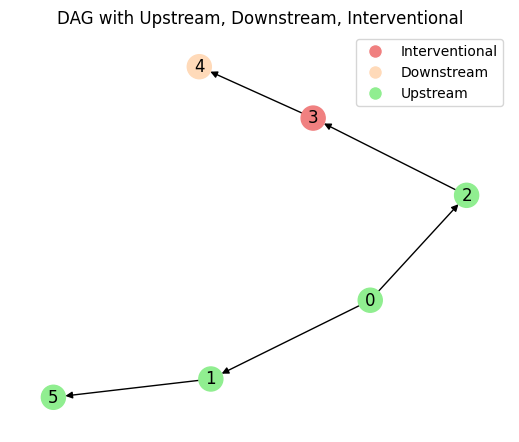

Unperturbed samples:
 [[ 0.003  0.001 -0.01  -0.001 -0.01  -0.002]
 [-0.01  -0.017 -0.009 -0.001  0.002 -0.012]
 [ 0.008  0.02   0.004  0.005 -0.005  0.023]
 [ 0.009  0.008  0.009  0.021  0.029  0.012]
 [-0.02  -0.024 -0.028 -0.023 -0.024 -0.019]]
Intervened samples:
 [[ 0.021  0.024  0.033  2.     2.007  0.026]
 [-0.004  0.005 -0.005  2.     2.005  0.011]
 [-0.005 -0.003 -0.014  2.     1.993 -0.017]
 [-0.008 -0.001 -0.016  2.     2.002 -0.005]
 [ 0.006  0.007  0.013  2.     2.001  0.002]]


In [21]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from iscm import data_sampler, graph_utils
np.set_printoptions(precision=3, suppress=True)

class LatentSCM:
    def __init__(
        self,
        n_nodes,
        edges,
        intervention_dict,
        base_weight=1.0,
        rng_seed=0,
        noise_variance=1e-5,
        noise_distribution="gaussian"
    ):
        """
        Construct a DAG and label nodes as upstream, downstream, or interventional,
        directly using a dictionary for do-interventions.
        
        Parameters
        ----------
        n_nodes : int
            Total number of nodes in the DAG.
        edges : list of tuples (u, v)
            Directed edges in the DAG, meaning u -> v.
        intervention_dict : dict
            Dictionary of potential do-interventions, e.g. {node_idx: do_value, ...}.
            All keys in this dict will be considered 'interventional nodes'.
        base_weight : float
            Baseline weight used for each edge in the adjacency/weight matrix.
        rng_seed : int
            Seed for the internal RNG.
        noise_variance : float
            Variance of the noise terms used in sampling.
        noise_distribution : str
            Distribution name for data_sampler (e.g. 'gaussian').
        """
        self.n_nodes = n_nodes
        self.edges = edges
        self.base_weight = base_weight
        self.noise_variance = noise_variance
        self.noise_distribution = noise_distribution
        self.rng = np.random.default_rng(rng_seed)
        
        # Store the "master" dictionary of potential do-interventions
        # All keys in this dict are 'interventional nodes'.
        self.intervention_dict = intervention_dict.copy()
        
        # Initialize adjacency/weight matrix
        self.weight_matrix = np.zeros((n_nodes, n_nodes))
        for (u, v) in edges:
            self.weight_matrix[u, v] = base_weight

        # Construct ds.py Graph
        self.graph = graph_utils.Graph(weight_matrix=self.weight_matrix)

        # Determine which nodes are interventional, downstream, upstream
        self._classify_nodes()
    
    def _classify_nodes(self):
        """
        Classify nodes as:
         - Interventional (keys of self.intervention_dict)
         - Downstream (descendants of any interventional node)
         - Upstream (all other nodes).
        """
        self.interventional_nodes = set(self.intervention_dict.keys())
        
        nx_graph = self.graph.get_nx_graph()
        
        # Gather all descendants of the interventional nodes
        all_descendants = set()
        for intv_node in self.interventional_nodes:
            all_descendants |= nx.descendants(nx_graph, intv_node)
        
        self.downstream_nodes = all_descendants - self.interventional_nodes
        all_nodes = set(range(self.n_nodes))
        self.upstream_nodes = all_nodes - self.interventional_nodes - self.downstream_nodes
    
    def sample(
        self,
        do_intervention_dict=None,
        sample_size=100,
        standardization="internal",
    ):
        """
        Sample from the DAG with a (possibly overridden) do-intervention dictionary.
        
        If do_intervention_dict is None, then we sample from the unperturbed system.
        
        Parameters
        ----------
        do_intervention_dict : dict, optional
            Dictionary of do-interventions to apply. Keys are node indices, 
            values are the do-values. If None, no interventions applied.
        sample_size : int
            Number of samples.
        standardization : str
            Standardization mode for data_sampler.
        
        Returns
        -------
        np.ndarray
            shape = (sample_size, n_nodes)
        """
        # If user passed no dictionary, sample unperturbed
        if do_intervention_dict is None:
            do_dict = {}
        else:
            do_dict = do_intervention_dict

        # Perform the sampling
        samples = data_sampler.sample_linear(
            graph=self.graph,
            do_interventions=do_dict,
            noise_variance=self.noise_variance,
            standardization=standardization,
            sample_size=sample_size,
            noise_distribution=self.noise_distribution,
            rng=self.rng,
        )
        return samples
    
    def plot_graph(self, title="Perturbed iSCM Graph"):
        """
        Plot the DAG, coloring interventional nodes, downstream, upstream.
        """
        nx_graph = self.graph.get_nx_graph()
        
        color_map = []

        
        for node in nx_graph.nodes():
            if node in self.interventional_nodes:
                color_map.append("lightcoral")
            elif node in self.downstream_nodes:
                color_map.append("peachpuff")
            else:
                color_map.append("lightgreen")
        
        plt.figure(figsize=(5, 4))
        pos = nx.spring_layout(nx_graph, seed=42)
        nx.draw(nx_graph, pos, node_color=color_map, with_labels=True)
        
        # Construct legend
        red_patch = plt.Line2D([0], [0], marker='o', color='w',
                               label='Interventional', markerfacecolor='lightcoral', markersize=10)
        blue_patch = plt.Line2D([0], [0], marker='o', color='w',
                                label='Downstream', markerfacecolor='peachpuff', markersize=10)
        green_patch = plt.Line2D([0], [0], marker='o', color='w',
                                 label='Upstream', markerfacecolor='lightgreen', markersize=10)
        
        plt.legend(handles=[red_patch, blue_patch, green_patch], loc='best')
        plt.title(title)
        plt.show()


if __name__ == "__main__":
    # ------------------------------------
    # Example usage
    # ------------------------------------
    # Suppose we have 6 nodes and edges:
    edges = [(0,1), (0,2), (2,3), (3,4), (1,5)]
    # Suppose we plan to intervene on node 3 with do(3)=2.0 in some experiments
    # (thus node 3 is an interventional node).
    # You could also define multiple nodes in the dictionary if you want.
    intervention_dict = {3: 2.0}

    # Create the system
    system = PerturbedISCM(
        n_nodes=6,
        edges=edges,
        intervention_dict=intervention_dict,
        base_weight=1.0,
        rng_seed=42,
        noise_variance=1e-4,
        noise_distribution="gaussian"
    )

    # The system labels:
    print("Interventional nodes:", system.interventional_nodes)
    print("Downstream nodes:", system.downstream_nodes)
    print("Upstream nodes:", system.upstream_nodes)

    system.plot_graph(title="DAG with Upstream, Downstream, Interventional")
    
    # Sample unperturbed
    samples_unperturbed = system.sample(do_intervention_dict=None, sample_size=5, standardization=None)
    print("Unperturbed samples:\n", samples_unperturbed)
    
    # Sample with the intervention do(3)=2.0
    samples_intervened = system.sample(do_intervention_dict={3: 2.0}, sample_size=5, standardization=None)
    print("Intervened samples:\n", samples_intervened)


Interventional nodes: {3}
Downstream nodes: {4}
Upstream nodes: {0, 1, 2, 5}


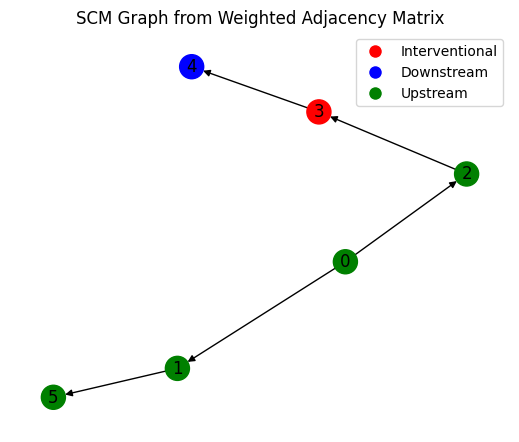

Unperturbed samples:
 [[ 0.404  0.401  0.399  0.401  0.394  0.399]
 [-0.674 -0.677 -0.671 -0.669 -0.665 -0.676]
 [ 0.761  0.768  0.761  0.757  0.749  0.769]
 [ 0.913  0.909  0.915  0.918  0.929  0.91 ]
 [-1.404 -1.402 -1.405 -1.406 -1.407 -1.402]]
Intervened samples:
 [[ 1.602  1.603  1.601  2.     1.016  1.603]
 [-0.506 -0.503 -0.504  2.     0.646 -0.499]
 [-0.593 -0.596 -0.595  2.    -1.589 -0.6  ]
 [-0.843 -0.842 -0.843  2.     0.071 -0.841]
 [ 0.34   0.338  0.342  2.    -0.143  0.336]]


In [23]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from iscm import data_sampler, graph_utils

class PerturbedISCM:
    def __init__(
        self,
        adjacency_matrix,
        intervention_dict,
        rng_seed=0,
        noise_variance=1e-5,
        noise_distribution="gaussian"
    ):
        """
        Construct an SCM from a user-supplied weighted adjacency matrix, labeling
        nodes as upstream, downstream, or interventional.

        Parameters
        ----------
        adjacency_matrix : np.ndarray
            A square (n x n) matrix describing the DAG. Nonzero entry [i, j]
            indicates a directed edge i -> j with weight adjacency_matrix[i, j].
        intervention_dict : dict
            Dictionary of potential do-interventions, e.g. {node_idx: do_value, ...}.
            All keys in this dict are considered 'interventional nodes'.
        rng_seed : int
            Seed for the internal RNG.
        noise_variance : float
            Variance of the noise terms used in sampling.
        noise_distribution : str
            Distribution name for data_sampler (e.g. 'gaussian').
        """
        self.adjacency_matrix = adjacency_matrix
        self.n_nodes = adjacency_matrix.shape[0]
        self.intervention_dict = intervention_dict.copy()
        self.noise_variance = noise_variance
        self.noise_distribution = noise_distribution
        self.rng = np.random.default_rng(rng_seed)

        # Build the graph object from ds.py
        self.graph = graph_utils.Graph(weight_matrix=self.adjacency_matrix)
        
        # Classify nodes
        self._classify_nodes()

    def _classify_nodes(self):
        """
        Classify nodes as:
         - Interventional (keys of self.intervention_dict)
         - Downstream (descendants of any interventional node)
         - Upstream (all other nodes).
        """
        self.interventional_nodes = set(self.intervention_dict.keys())

        # Use NetworkX to find descendants
        nx_graph = self.graph.get_nx_graph()

        all_descendants = set()
        for intv_node in self.interventional_nodes:
            all_descendants |= nx.descendants(nx_graph, intv_node)

        # Downstream = all_descendants minus any interventional node
        self.downstream_nodes = all_descendants - self.interventional_nodes

        all_nodes = set(range(self.n_nodes))
        self.upstream_nodes = all_nodes - self.interventional_nodes - self.downstream_nodes

    def sample(
        self,
        do_intervention_dict=None,
        sample_size=100,
        standardization="internal",
    ):
        """
        Sample from the SCM with (possibly overridden) do-interventions.
        If do_intervention_dict is None, we sample from the unperturbed system.

        Parameters
        ----------
        do_intervention_dict : dict, optional
            Dictionary of do-interventions to apply. Keys are node indices,
            values are the do-values. If None, no interventions are applied.
        sample_size : int
            Number of samples to draw.
        standardization : str
            Standardization mode for data_sampler.

        Returns
        -------
        np.ndarray
            shape = (sample_size, n_nodes).
        """
        # If user provides no dictionary, sample unperturbed
        if do_intervention_dict is None:
            do_dict = {}
        else:
            do_dict = do_intervention_dict

        samples = data_sampler.sample_linear(
            graph=self.graph,
            do_interventions=do_dict,
            noise_variance=self.noise_variance,
            standardization=standardization,
            sample_size=sample_size,
            noise_distribution=self.noise_distribution,
            rng=self.rng,
        )
        return samples

    def plot_graph(self, title="SCM Graph"):
        """
        Plot the DAG, coloring interventional nodes (red), downstream (blue), upstream (green).
        Each node is labeled by its integer index to match adjacency matrix ordering.
        """
        nx_graph = self.graph.get_nx_graph()

        # Build color map
        color_map = []
        for node in nx_graph.nodes():
            if node in self.interventional_nodes:
                color_map.append("red")
            elif node in self.downstream_nodes:
                color_map.append("blue")
            else:
                color_map.append("green")

        # Create positions and label dict
        pos = nx.spring_layout(nx_graph, seed=42)
        labels = {node: str(node) for node in range(self.n_nodes)}

        plt.figure(figsize=(5, 4))
        nx.draw(
            nx_graph,
            pos,
            node_color=color_map,
            labels=labels,  # ensures each node is labeled with its own index
            with_labels=True
        )

        # Construct legend
        red_patch = plt.Line2D([0], [0], marker='o', color='w',
                               label='Interventional', markerfacecolor='red', markersize=10)
        blue_patch = plt.Line2D([0], [0], marker='o', color='w',
                                label='Downstream', markerfacecolor='blue', markersize=10)
        green_patch = plt.Line2D([0], [0], marker='o', color='w',
                                 label='Upstream', markerfacecolor='green', markersize=10)
        
        plt.legend(handles=[red_patch, blue_patch, green_patch], loc='best')
        plt.title(title)
        plt.show()


if __name__ == "__main__":
    # ---------------------------------------------------------
    # Example usage with a 6 x 6 adjacency matrix
    # ---------------------------------------------------------
    adjacency_matrix = np.array([
        #   0   1    2    3    4    5
        [0.0, 1.2, 2.0, 0.0, 0.0, 0.0],  # Node 0 -> Node 1, Node 0 -> Node 2
        [0.0, 0.0, 0.0, 0.0, 0.0, 2.5],  # Node 1 -> Node 5
        [0.0, 0.0, 0.0, 1.5, 0.0, 0.0],  # Node 2 -> Node 3
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],  # Node 3 -> Node 4
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # Node 4 has no children
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # Node 5 has no children
    ])

    # Suppose we plan to intervene on node 3 with do(3)=2.0 (making node 3 an interventional node)
    intervention_dict = {3: 2.0}

    # Create system from adjacency matrix
    system = PerturbedISCM(
        adjacency_matrix=adjacency_matrix,
        intervention_dict=intervention_dict,
        rng_seed=42,
        noise_variance=1e-4,
        noise_distribution="gaussian"
    )

    # Check classification
    print("Interventional nodes:", system.interventional_nodes)
    print("Downstream nodes:", system.downstream_nodes)
    print("Upstream nodes:", system.upstream_nodes)

    # Plot to confirm node categories
    system.plot_graph(title="SCM Graph from Weighted Adjacency Matrix")

    # Sample from unperturbed system
    unperturbed_samples = system.sample(do_intervention_dict=None, sample_size=5)
    print("Unperturbed samples:\n", unperturbed_samples)

    # Sample with do(3) = 2.0
    intervened_samples = system.sample(do_intervention_dict={3: 2.0}, sample_size=5)
    print("Intervened samples:\n", intervened_samples)
